# I. HIỂU BIẾT VỀ KINH DOANH (BUSINESS UNDERSTANDING)

## 1.1 Vấn đề kinh doanh
Khách hàng là một công ty giao thức ăn hoạt động ở nhiều thành phố. Họ có nhiều trung tâm khác nhau để xử lý các đơn đặt hàng cho khách hàng của họ. Họ muốn bạn giúp các trung tâm này dự báo nhu cầu khách hàng cho các tuần sắp tới, qua đó có cơ sở giúp công ty giải quyết được 02 vấn đề sau:
* Thiếu/ thừa nguyên liệu do không biết trước nhu cầu khách hàng, làm giảm sự hài lòng của khách hàng và lãng phí cho công ty.
* Thiếu/ thừa nhân sự phục vụ tại các thời điểm khác nhau.

Chi tiết: https://datahack.analyticsvidhya.com/contest/genpact-machine-learning-hackathon-1/#ProblemStatement

## 1.2 Mục tiêu
Mục tiêu của đồ án là dự đoán nhu cầu đặt hàng trong 10 tuần tới (Tuần: 146-155) cho mỗi loại món ăn của các trung tâm trong tập dữ liệu kiểm tra (test set).

## 1.3 Các yếu tố ảnh hưởng đến nhu cầu khách hàng
* Giá cả
* Tính chất món ăn
* Các chương trình khuyến mãi
* Các đặc điểm nhân khẩu học (dân số, tuổi, giới tính, vùng miền, kinh tế, v.v)
* Các yếu tố khác

## 1.4 Tiêu chí đánh giá
* Dự án được đánh giá bằng sai số 100*RMSLE, trong đó RMSLE là Root Mean Squared Logarithmic Error của dự đoán trên tập test set.
* Dự án được đánh giá là đạt yêu cầu khi sai số nhỏ hơn hoặc bằng sai số của 10% kết quả tốt nhất trên bảng xếp hạng của Analytics Vidhya (https://datahack.analyticsvidhya.com/contest/genpact-machine-learning-hackathon-1/#LeaderBoard). 
* Tại thời điểm của dự án, tiêu chí sai số là nhỏ hơn 52.5823376761 hoặc RMSLE nhỏ hơn 0.525 (hạng 166/1779, tương đương 10% kết quả tốt nhất)

# II. PREPROCESSING (TIỀN XỬ LÝ DỮ LIỆU)

## 2.1 Cài đặt ban đầu

Cài đặt các package cần cho dự án & kết nối với cơ sở dữ liệu

In [ ]:
#importing required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
!pip install catboost
from catboost import CatBoostRegressor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.1 MB/s 


In [ ]:
## Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/Food Data/' # folder containing data

Mounted at /content/drive


## 2.2 Tải dữ liệu vào các data frame

**Dữ liệu huấn luyện (train.csv):**

Bảng chứa dữ liệu cầu lịch sử đặt hàng của tất cả các trung tâm. Số bản ghi: 456,548. Giải thích danh tính các trường:

| Trường | Danh tính |
|-|-|
| id | ID của bản ghi |
| week | Số thứ tự tuần, nhỏ nhất là 1 |
| center_id | ID của trung tâm |
| meal_id | ID của món ăn |
| checkout_price | Giá thực trả |
| base_price | Giá gốc |
| emailer_for_promotion | Chương trình khuyến mãi của món ăn được gửi qua email |
| homepage_featured | Món ăn được giới thiệu trên trang chủ |
| num_orders | Số lượng đặt hàng (biến mục tiêu) |

 

In [ ]:
df_train = pd.read_csv(path + 'train.csv')
df_train

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40
...,...,...,...,...,...,...,...,...,...
456543,1271326,145,61,1543,484.09,484.09,0,0,68
456544,1062036,145,61,2304,482.09,482.09,0,0,42
456545,1110849,145,61,2664,237.68,321.07,0,0,501
456546,1147725,145,61,2569,243.50,313.34,0,0,729


**Thông tin các loại món ăn (meal_info.csv):**

Chứa thông tin của mỗi loại món ăn được phục vụ. Số bản ghi: 51. Giải thích danh tính các trường:

| Trường | Danh tính |
|-|-|
| meal_id | ID của món ăn |
| category | Phân loại món ăn (đồ uống/ đồ ăn nhẹ/ súp …) |
| cuisine | Loại ẩm thực (Ấn Độ/ Ý/ Thái Lan …) |

 

In [ ]:
df_meal = pd.read_csv(path + 'meal_info.csv')
df_meal

,meal_id,category,cuisine
0,1885,Beverages,Thai
1,1993,Beverages,Thai
2,2539,Beverages,Thai
3,1248,Beverages,Indian
4,2631,Beverages,Indian
5,1311,Extras,Thai
6,1062,Beverages,Italian
7,1778,Beverages,Italian
8,1803,Extras,Thai
9,1198,Extras,Thai


**Thông tin các trung tâm (fulfilment_center_info.csv):**

Chứa thông tin của mỗi trung tâm. Số bản ghi: 77. Giải thích danh tính các trường:

| Trường | Danh tính |
|-|-|
| center_id | ID của trung tâm |
| city_code | Mã thành phố |
| region_code | Mã vùng |
| center_type | Loại trung tâm |
| op_area | Phạm vi hoạt động (đơn vị: km2) |

 

In [ ]:
df_center = pd.read_csv(path + 'fulfilment_center_info.csv')
df_center

,center_id,city_code,region_code,center_type,op_area
0,11,679,56,TYPE_A,3.7
1,13,590,56,TYPE_B,6.7
2,124,590,56,TYPE_C,4.0
3,66,648,34,TYPE_A,4.1
4,94,632,34,TYPE_C,3.6
...,...,...,...,...,...
72,53,590,56,TYPE_A,3.8
73,30,604,56,TYPE_A,3.5
74,76,614,85,TYPE_A,3.0
75,68,676,34,TYPE_B,4.1


## 2.3 Hợp nhất các data frame

In [ ]:
df_merged_temp = pd.merge(df_train, df_meal , on='meal_id')
df = pd.merge(df_merged_temp, df_center , on='center_id')
df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine,city_code,region_code,center_type,op_area
0,1379560,1,55,1885,136.83,152.29,0,0,177,Beverages,Thai,647,56,TYPE_C,2.0
1,1018704,2,55,1885,135.83,152.29,0,0,323,Beverages,Thai,647,56,TYPE_C,2.0
2,1196273,3,55,1885,132.92,133.92,0,0,96,Beverages,Thai,647,56,TYPE_C,2.0
3,1116527,4,55,1885,135.86,134.86,0,0,163,Beverages,Thai,647,56,TYPE_C,2.0
4,1343872,5,55,1885,146.50,147.50,0,0,215,Beverages,Thai,647,56,TYPE_C,2.0


# III. DATA UNDERSTANDING (HIỂU BIẾT VỀ DỮ LIỆU)

## 3.1 Mô tả dữ liệu đã được thu thập

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 456548 entries, 0 to 456547
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     456548 non-null  int64  
 1   week                   456548 non-null  int64  
 2   center_id              456548 non-null  int64  
 3   meal_id                456548 non-null  int64  
 4   checkout_price         456548 non-null  float64
 5   base_price             456548 non-null  float64
 6   emailer_for_promotion  456548 non-null  int64  
 7   homepage_featured      456548 non-null  int64  
 8   num_orders             456548 non-null  int64  
 9   category               456548 non-null  object 
 10  cuisine                456548 non-null  object 
 11  city_code              456548 non-null  int64  
 12  region_code            456548 non-null  int64  
 13  center_type            456548 non-null  object 
 14  op_area                456548 non-nu

Số bản ghi là 456548, bao gồm các kiểu dữ liệu int64, float64, object

In [ ]:
df.nunique()

id                       456548
week                        145
center_id                    77
meal_id                      51
checkout_price             1992
base_price                 1907
emailer_for_promotion         2
homepage_featured             2
num_orders                 1250
category                     14
cuisine                       4
city_code                    51
region_code                   8
center_type                   3
op_area                      30
dtype: int64

Các giá trị duy nhất của từng trường như trên, không có hai bản ghi nào trùng nhau (số lượng "id" duy nhất bằng với số bản ghi)

In [ ]:
#for checking null values
df.isnull().sum()

id                       0
week                     0
center_id                0
meal_id                  0
checkout_price           0
base_price               0
emailer_for_promotion    0
homepage_featured        0
num_orders               0
category                 0
cuisine                  0
city_code                0
region_code              0
center_type              0
op_area                  0
dtype: int64

Dữ liệu không chứa giá trị null

## 3.2 Phân tích dữ liệu khám phá (EDA)

### 3.2.1 Tương quan giữa các đặc trưng (Correlation)

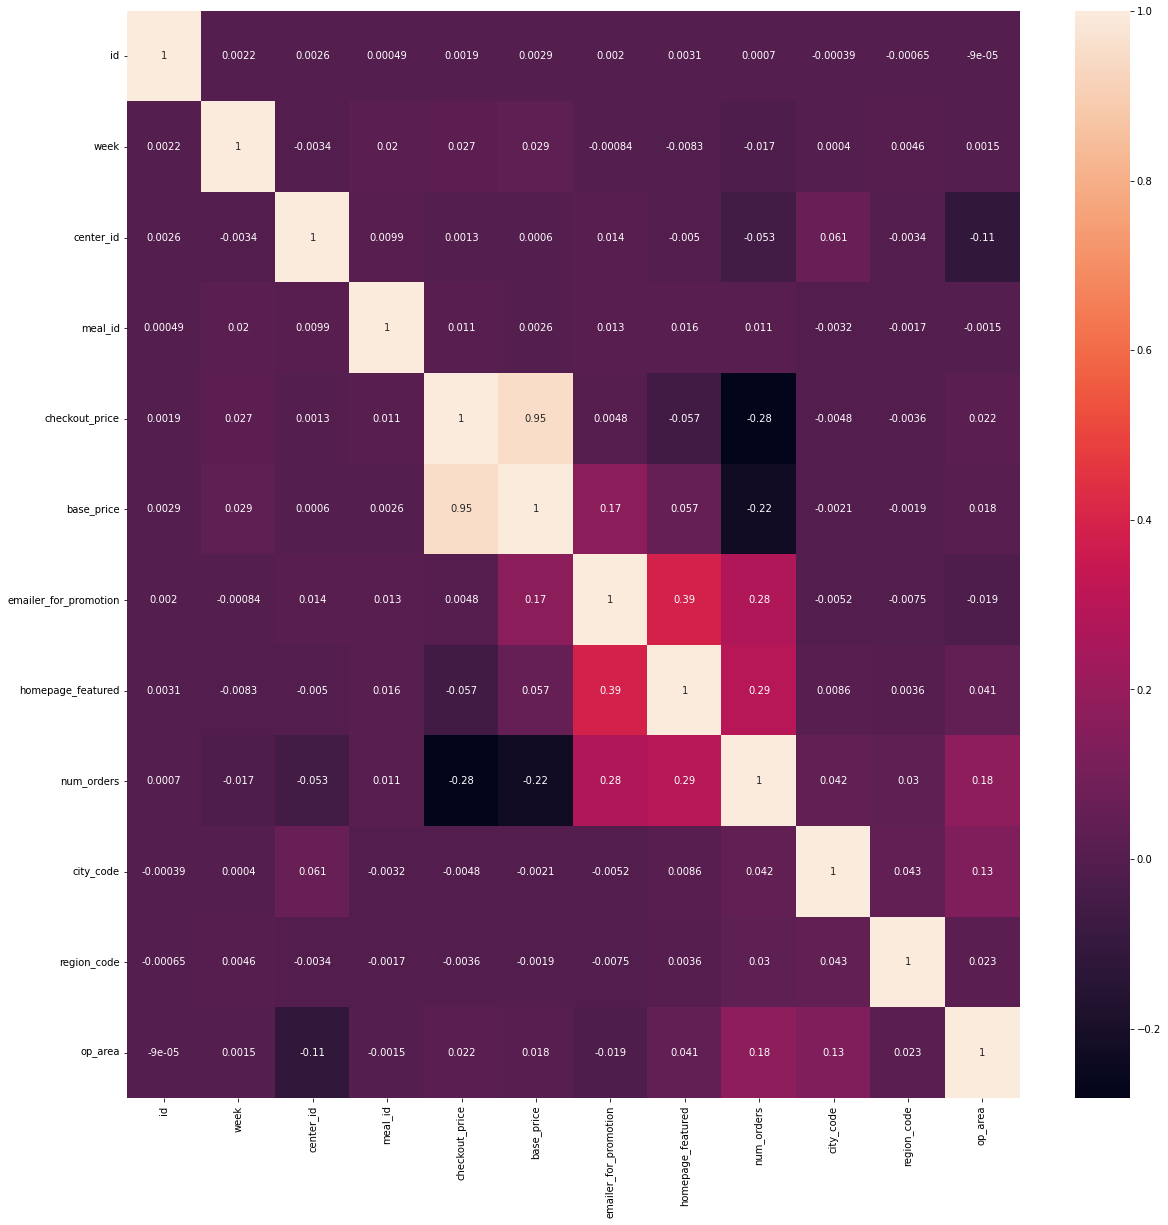

In [ ]:
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(),annot=True)

Với biến phụ thuộc (output) là "num_orders", một số đặc trưng (feature) có hệ số tương quan cao nhất là:
* checkout_price
* base_price
* emailer_promotion
* homepage_featured
* op_area

### 3.2.1 Phân phối của dữ liệu (Distribution)

#### **num_orders (output)**
* Phân phối lệch phải (right-skewed) tương đối lớn.
* Phần lớn giá trị của num_orders tập trung trong khoảng 0-2000
---
Nhận xét: Đa số các món ăn được đặt hàng dưới 2000 đơn/ trung tâm/ tuần trong phần lớn thời gian

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


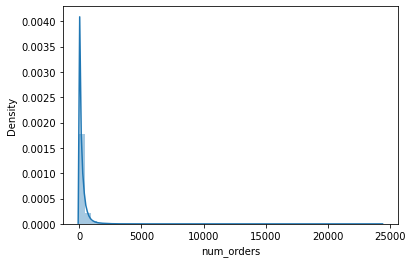

In [ ]:
sns.distplot(df['num_orders'])

#### **center_id**
* Đa số các center_id có số num_orders cao nhất khoảng 5000
* Một số center_id có num_orders cao hơn, ví dụ center_id 48 có số num_orders cao hơn các center khác
---
Nhận xét: num_orders có thể phụ thuộc vào center_id. Số đơn đặt hàng phụ thuộc vào từng trung tâm phân phối.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


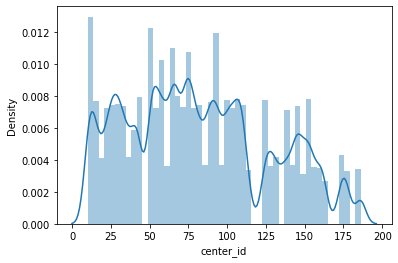

In [ ]:
sns.distplot(df['center_id'],kde=True)

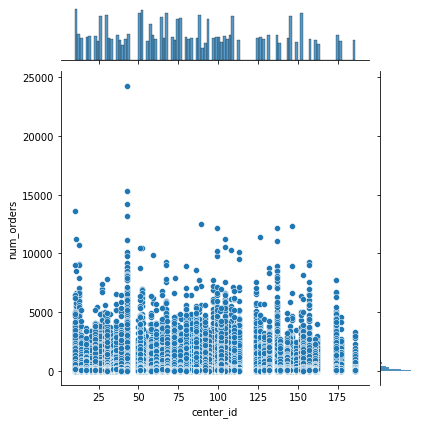

In [ ]:
sns.jointplot(x='center_id',y='num_orders',data=df)

#### **week**
* Đa số các week có số num_orders cao nhất khoảng 5000
* Một số week có num_orders cao hơn, ví dụ week 5 có số num_orders cao đột biến
* Một số week có num_orders thấp hơn, ví dụ week 15, 35, 55, 65, 85 có số num_orders thấp hơn đa số các week còn lại. 
---
Nhận xét: num_orders có thể giảm đáng kể sau một khoảng thời gian. Khách hàng có thể giảm nhu cầu sau một khoảng thời gian.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


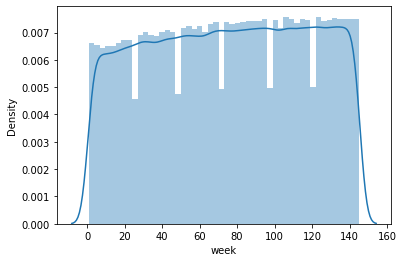

In [ ]:
sns.distplot(df['week'],kde=True)

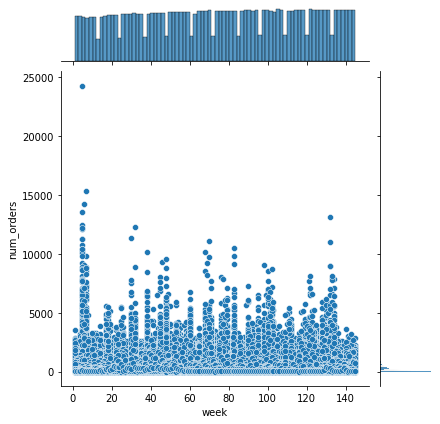

In [ ]:
sns.jointplot(x='week',y='num_orders',data=df)

#### **meal_id**
* Đa số các meal_id có số num_orders cao nhất khoảng 2000
* Một số meal_id có num_orders cao hơn, ví dụ meal_id khoảng 2300 có số num_orders cao đột biến
* Một số meal_id có num_orders thấp hơn, ví dụ meal_id khoảng 2100 có số num_orders thấp hơn đa số các meal_id còn lại 
---
Nhận xét: num_orders có thể phụ thuộc vào meal_id. Khách hàng có xu hướng đặt hàng một số loại món ăn nhiều hơn/ ít hơn các loại khác.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


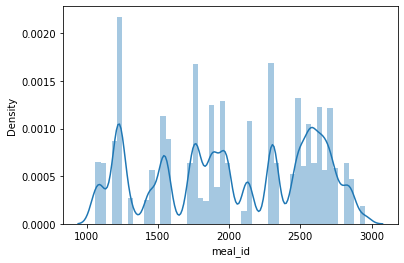

In [ ]:
sns.distplot(df['meal_id'],kde=True)

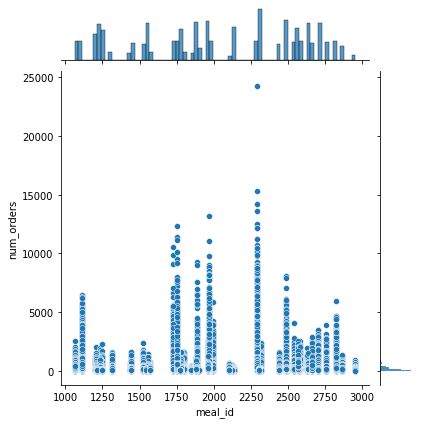

In [ ]:
sns.jointplot(x='meal_id',y='num_orders',data=df)

#### **checkout_price**
* Phân phối có xu hướng lệch phải (right-skewed).
* Đa số các num_orders cao nhất (trên 7000) tương ứng với checkout_price dưới 300
* checkout_price xung quanh giá trị 200 có số num_orders cao nhất  (15000)
* checkout_price cao hơn 300 có xu hướng có num_orders thấp dần.
---
Nhận xét: num_orders có thể phụ thuộc vào checkout_price. Giá tiền cao có thể làm giảm số đơn hàng.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


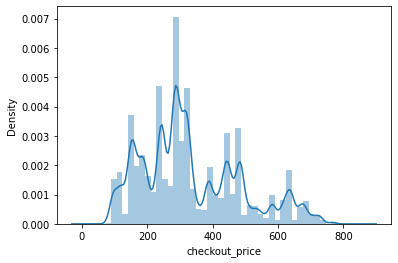

In [ ]:
sns.distplot(df['checkout_price'],kde=True)

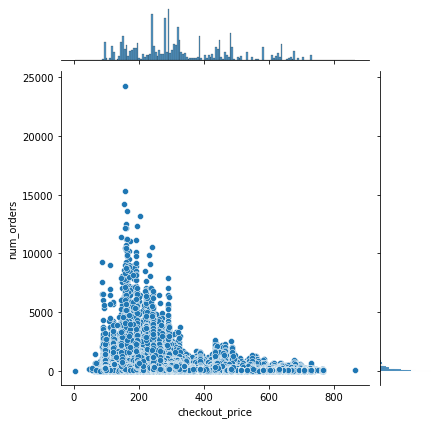

In [ ]:
sns.jointplot(x='checkout_price',y='num_orders',data=df)

#### **base_price**
* Phân phối có xu hướng lệch phải (right-skewed).
* base_price xung quanh giá trị 300 có số num_orders cao nhất (15000)
* Đa số các num_orders cao nhất (trên 7000) tương ứng với base_price dưới 500
* base_price cao hơn 500 có xu hướng có num_orders thấp hơn.
---
Nhận xét: num_orders có thể phụ thuộc vào base_price. Giá tiền cao có thể làm giảm số đơn hàng.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


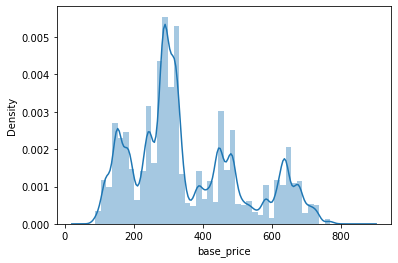

In [ ]:
sns.distplot(df['base_price'],kde=True)

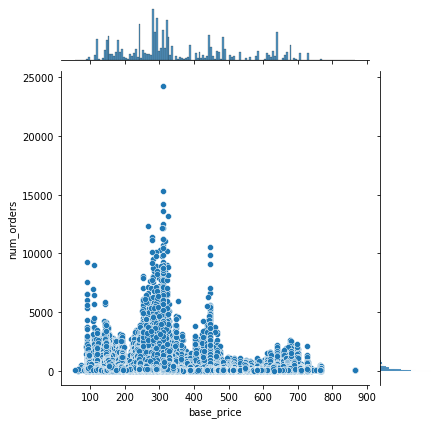

In [ ]:
sns.jointplot(x='base_price',y='num_orders',data=df)

#### **city_code**
* Một số city_code có num_orders cao hơn.
* Đa số các city_code trong khoảng 580-650 có num_orders cao nhất (trên 7000) 
---
Nhận xét: num_orders có thể phụ thuộc vào city_code. Các thành phố khác nhau có quy mô nhu cầu khác nhau.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


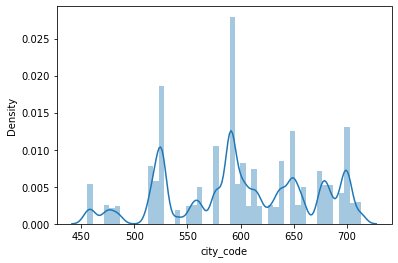

In [ ]:
sns.distplot(df['city_code'],kde=True)

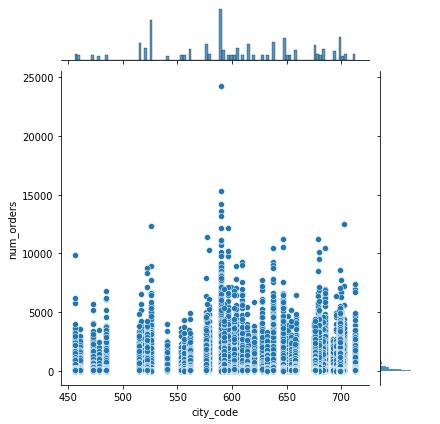

In [ ]:
sns.jointplot(x='city_code',y='num_orders',data=df)

#### **op_area**
* op_area lớn hơn có xu hướng có num_orders cao hơn
* op_area có giá trị trong khoảng 5-6.7 có num_orders cao nhất
---
Nhận xét: num_orders có thể phụ thuộc vào op_area. Các trung tâm phụ trách khu vực lớn hơn có thể có nhu cầu lơn hơn.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


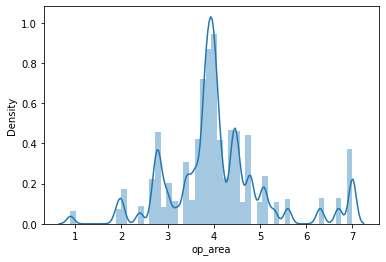

In [ ]:
sns.distplot(df['op_area'], kde=True)

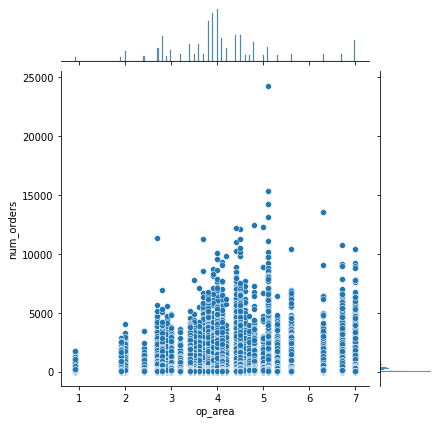

In [ ]:
sns.jointplot(x='op_area', y='num_orders', data=df)

#### **emailer_for_promotion**
* emailer_for_promotion 1 có trung bình num_orders cao hơn
* emailer_for_promotion 0 có trung bình num_orders thấp hơn (chỉ bằng khoảng 30% so với emailer_for_promotion 1)
---
Nhận xét: num_orders có thể phụ thuộc vào emailer_for_promotion. Việc gửi email quảng cáo có thể làm tăng nhu cầu của món ăn.

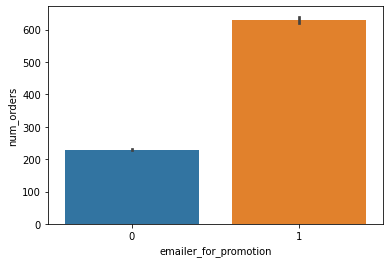

In [ ]:
sns.barplot(x='emailer_for_promotion', y='num_orders', data=df)

#### **homepage_featured**
* homepage_featured 1 có trung bình num_orders cao hơn
* homepage_featured 0 có trung bình num_orders thấp hơn (chỉ bằng khoảng 30% so với homepage_featured 1)
---
Nhận xét: num_orders có thể phụ thuộc vào homepage_featured. Việc đưa món ăn lên giao diện đại diện của trang chủ website có thể làm tăng nhu cầu của món ăn.

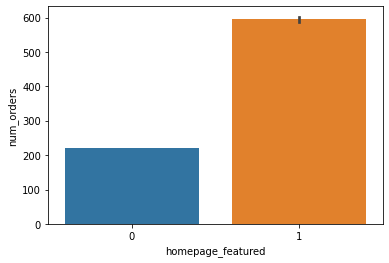

In [ ]:
sns.barplot(x='homepage_featured', y='num_orders', data =df)

#### **category**
* category khác nhau có trung bình num_orders khác nhau.
* Rice Bowl (có trung bình num_orders cao nhất) cao hơn khoảng 20 lần so với Biryani (có trung bình num_orders thấp nhất)
---
Nhận xét: num_orders có thể phụ thuộc vào category. Các loại món ăn khác nhau có nhu cầu khác nhau.

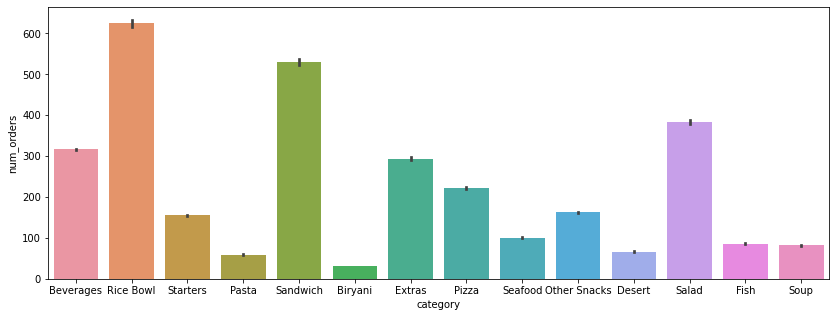

In [ ]:
plt.figure(figsize=(14,5))
sns.barplot(x='category', y='num_orders', data=df)

#### **cuisine**
* cuisine khác nhau có trung bình num_orders khác nhau.
* Italian (có trung bình num_orders cao nhất) cao hơn khoảng 2 lần so với Continental (có trung bình num_orders thấp nhất)
---
Nhận xét: num_orders có thể phụ thuộc vào cuisine. Các phong cách ẩm thực khác nhau có nhu cầu khác nhau.

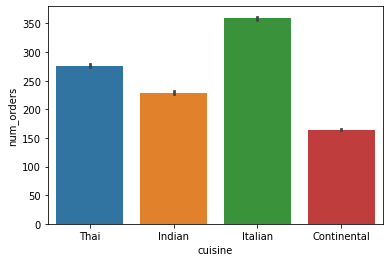

In [ ]:
sns.barplot(x='cuisine', y='num_orders', data=df)

#### **region_code**
* region_code khác nhau có trung bình num_orders khác nhau.
* region_code 56 và 71 có trung bình num_orders tương đối cao hơn.
---
Nhận xét: num_orders có thể phụ thuộc vào region_code. Các khu vực khác nhau có nhu cầu khác nhau.

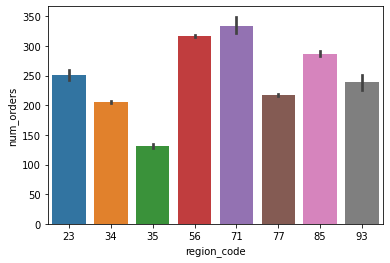

In [ ]:
sns.barplot(x='region_code', y='num_orders', data=df)

#### **center_type**
* center_type khác nhau có trung bình num_orders khác nhau.
* center_type B có trung bình num_orders cao hơn A và C.
---
Nhận xét: num_orders có thể phụ thuộc vào center_type. Các đơn đặt hàng từ Trung tâm loại B có thể cao hơn các loại khác.

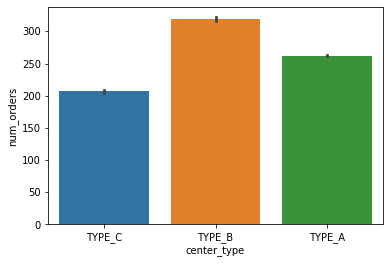

In [ ]:
sns.barplot(x='center_type',y='num_orders',data =df)

# IV. FEATURE ENGINEERING (XỬ LÝ CÁC ĐẶC TRƯNG)

## 4.1 Log Transformation
Biến đổi Log Transformation các đặc trưng có phân phối lệch phải đã phát hiện:
* num_orders
* checkout_price
* base_price

In [ ]:
train_data = df.copy()
train_data.shape

(456548, 15)

In [ ]:
train_data['num_orders']=np.log1p(train_data['num_orders'])
train_data['checkout_price'] = np.log1p(train_data['checkout_price'])
train_data['base_price'] = np.log1p(train_data['base_price'])

Phân phối của các đặc trưng sau khi biến đổi Log Transformation: đã giảm độ lệch

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


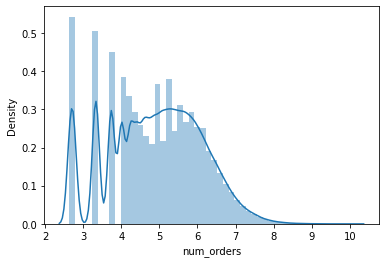

In [ ]:
sns.distplot(train_data['num_orders'],kde=True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


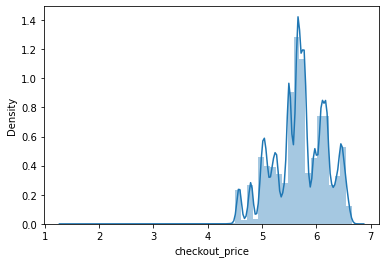

In [ ]:
sns.distplot(train_data['checkout_price'],kde=True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


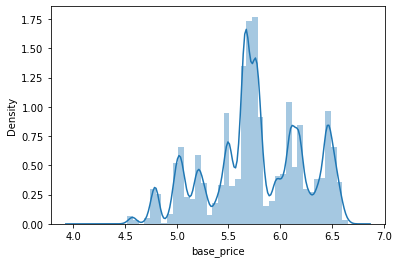

In [ ]:
sns.distplot(train_data['base_price'],kde=True)

## 4.2 Mã hóa dữ liệu (Encoding)
Mã hóa các đặc trưng dạng phân loại (categorical - object) về số nguyên (int64) theo yêu cầu dữ liệu đầu vào của các framework thuật toán sẽ sử dụng. Các đặc trưng được mã hóa:
* category
* cuisine
* center_type

In [ ]:
# Encode features
features_encode = ['category', 'cuisine','center_type']

le = LabelEncoder()
train_data[features_encode] = train_data[features_encode].apply(le.fit_transform)

## 4.3 Lựa chọn đặc trưng (Feature Selection)

**Kiểm tra dữ lại dữ liệu: Không chưa giá trị null, số bản ghi và loại dữ liệu phù hợp**

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 456548 entries, 0 to 456547
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     456548 non-null  int64  
 1   week                   456548 non-null  int64  
 2   center_id              456548 non-null  int64  
 3   meal_id                456548 non-null  int64  
 4   checkout_price         456548 non-null  float64
 5   base_price             456548 non-null  float64
 6   emailer_for_promotion  456548 non-null  int64  
 7   homepage_featured      456548 non-null  int64  
 8   num_orders             456548 non-null  float64
 9   category               456548 non-null  int64  
 10  cuisine                456548 non-null  int64  
 11  city_code              456548 non-null  int64  
 12  region_code            456548 non-null  int64  
 13  center_type            456548 non-null  int64  
 14  op_area                456548 non-nu

**Lập danh sách tất cả các đặc trưng của dữ liệu**


In [ ]:
features = list(train_data.drop(['id', 'num_orders'], axis=1).columns)
features

['week',
 'center_id',
 'meal_id',
 'checkout_price',
 'base_price',
 'emailer_for_promotion',
 'homepage_featured',
 'category',
 'cuisine',
 'city_code',
 'region_code',
 'center_type',
 'op_area']

**Tương quan giữa các đặc trưng sau khi xử lý**

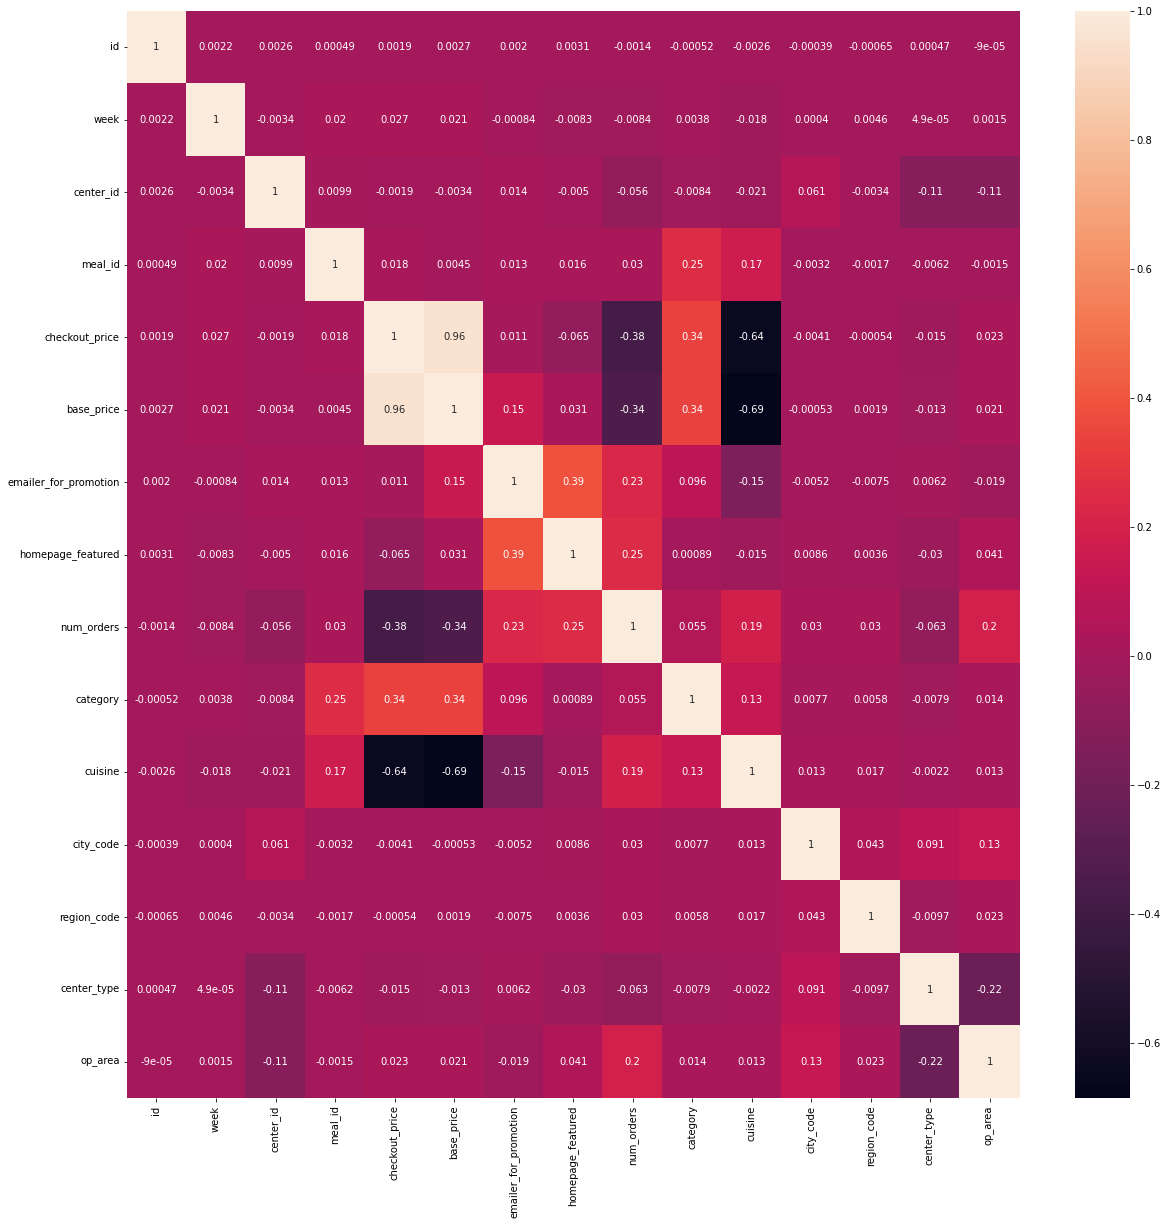

In [ ]:
plt.figure(figsize=(20, 20))
sns.heatmap(train_data.corr(),annot=True)

**Độ lớn giá trị tương quan giữa output (num_orders) và các đặc trưng, từ cao tới thấp**            

In [ ]:
abs(train_data.corr()['num_orders']).sort_values(ascending=False)

num_orders               1.000000
checkout_price           0.377399
base_price               0.338953
homepage_featured        0.248957
emailer_for_promotion    0.227997
op_area                  0.195314
cuisine                  0.188148
center_type              0.062991
center_id                0.055720
category                 0.054760
city_code                0.030381
meal_id                  0.029933
region_code              0.029817
week                     0.008401
id                       0.001355
Name: num_orders, dtype: float64

**Các đặc trưng được chọn:** 

Chọn tất cả đặc trưng, việc thêm hay loại bỏ đặc trưng sẽ được thực hiện trong quá trình thử nghiệm mô hình.

In [ ]:
features_selected = features.copy()
features_selected

['week',
 'center_id',
 'meal_id',
 'checkout_price',
 'base_price',
 'emailer_for_promotion',
 'homepage_featured',
 'category',
 'cuisine',
 'city_code',
 'region_code',
 'center_type',
 'op_area']

# V. LẬP MÔ HÌNH (MODELING)

## 5.1 Chia dữ liệu huấn luyện / đánh giá (Train / Validation Data Splitting)
Chia dữ liệu huấn luyện (train_data) thành 02 bộ huấn luyện / kiểm tra theo tỉ lệ 7:3

In [ ]:
def data_split(data_x, data_y):
  X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.3, random_state=9)
  return X_train, X_val, y_train, y_val

X_train, X_val, y_train, y_val = data_split(train_data[features_selected], train_data['num_orders'])
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((319583, 13), (136965, 13), (319583,), (136965,))

## 5.2 Chuẩn bị dữ liệu kiểm tra (Test Data)
Load và xử lý bộ dữ liệu kiểm tra (test.csv)

In [ ]:
# Load & merge data
df_test = pd.read_csv(path + 'test.csv')
test_id = df_test['id']
df_merged_temp = pd.merge(df_test, df_meal, on='meal_id')
test_data = pd.merge(df_merged_temp, df_center, on='center_id')

# Log Transformation
test_data['checkout_price'] = np.log1p(test_data['checkout_price'])
test_data['base_price'] = np.log1p(test_data['base_price'])

# Label encode
le = LabelEncoder()
test_data[features_encode] = test_data[features_encode].apply(le.fit_transform)

# Test input
X_test = test_data.copy()[features_selected]
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32573 entries, 0 to 32572
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   week                   32573 non-null  int64  
 1   center_id              32573 non-null  int64  
 2   meal_id                32573 non-null  int64  
 3   checkout_price         32573 non-null  float64
 4   base_price             32573 non-null  float64
 5   emailer_for_promotion  32573 non-null  int64  
 6   homepage_featured      32573 non-null  int64  
 7   category               32573 non-null  int64  
 8   cuisine                32573 non-null  int64  
 9   city_code              32573 non-null  int64  
 10  region_code            32573 non-null  int64  
 11  center_type            32573 non-null  int64  
 12  op_area                32573 non-null  float64
dtypes: float64(3), int64(10)
memory usage: 3.5 MB


## 5.3 Thuật toán (Algorithm)
Dự án sẽ áp dụng thuật toán học máy Gradient Boosting do tính ưu việt so với các thuật toán đơn lẻ. Sau đây sẽ tiến hành thử nghiệm trên  03 framework Gradient Boosting phổ biến nhất hiện nay:
* XGBoost
* LightGBM
* CatBoost

## 5.4 Tham số (Parameters)

Các tham số sẽ tiến hành cài đặt và điều chỉnh (tuning) bao gồm:

| Tham số | Key | XGBoost | LightGBM | CatBoost |
|-|-|-|-|-|
| Độ sâu cây gradient boosting | tree_depth | max_depth | max_depth | max_depth |
| Số cây gradient boosting | tree_num | n_estimators | num_iterations | iterations |
| Hệ số chính quy hóa L2 | L2_reg | lambda | lambda_l2 | l2_leaf_reg |

## 5.5 Module huấn luyện (Training Module)

In [ ]:
def create_model(model_name, params):
  if model_name == 'XGBoost':
    model = XGBRegressor(
      max_depth=params['tree_depth'],
      n_estimators=params['tree_num'],
      lamba=params['L2_reg'],
      objective='reg:linear',
      eval_metric='rmse',
      random_state=9,
      tree_method='gpu_hist', #turn on if gpu is available for more speed
      verbose=0)
  if model_name == 'LightGBM':
    model = LGBMRegressor(
      max_depth=params['tree_depth'],
      num_iterations=params['tree_num'],
      lambda_l2=params['L2_reg'],
      objective='regression',
      boosting_type='gbdt',
      metric='rmse',
      random_state=9,
      verbose=-1)
  if model_name == 'CatBoost':
    model = CatBoostRegressor(
      max_depth=params['tree_depth'],
      iterations=params['tree_num'], 
      l2_leaf_reg=params['L2_reg'],
      loss_function='RMSE',
      od_type='Iter',
      od_wait=20,
      random_seed=9, 
      task_type="GPU",  #turn on if gpu is available for more speed
      verbose=0)
  return model
      
def train_model(model_name, params, X_train, y_train, X_val, y_val):
  model = create_model(model_name, params)
  if model_name == 'XGBoost' or model_name == 'LightGBM':
    model.fit(
        X_train, y_train, 
        eval_set=[(X_train, y_train), (X_val, y_val)], 
        early_stopping_rounds=20, verbose=False) 
  if model_name == 'CatBoost':
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

  return model

## 5.6 Module kiểm tra (Testing Module)

In [ ]:
def get_prediction_test(model, X_test):
  result = np.expm1(model.predict(X_test)).astype('int64') # reverse log transformation

  y_pred = pd.DataFrame()
  y_pred['num_orders'] = result
  y_pred['id'] = test_data['id']

  submission = pd.DataFrame()
  submission['id'] = test_id
  submission = pd.merge(submission, y_pred, on='id')
  submission = submission[['id', 'num_orders']]
  return submission

def test_model(model, X_test):
  submission = get_prediction_test(model, X_test)
  submission.to_csv(path + 'submission.csv', index=False)

  RMSLE_train = mean_squared_log_error(y_train, model.predict(X_train))
  RMSLE_val = mean_squared_log_error(y_val, model.predict(X_val))

  return RMSLE_train, RMSLE_val

# save model info and performance to file
def save_result(model_name, features, params, RMSLE_train, RMSLE_val, RMSLE_test):
  try:
    history_models = pd.read_csv(path + 'history_models.csv', index_col=None)
  except:
    history_models = pd.DataFrame(columns=['model_name', 'features', 'tree_depth', 'tree_num', 'L2_reg', 'RMSLE_train', 'RMSLE_val', 'RMSLE_test'])

  update = pd.DataFrame([[model_name, str(features), params['tree_depth'], params['tree_num'], params['L2_reg'], RMSLE_train, RMSLE_val, RMSLE_test / 100]], columns=history_models.columns)
  history_models = history_models.append(update)
  history_models = history_models.reset_index().drop(['index'], axis=1)
  history_models.to_csv(path + 'history_models.csv', index=False)

  print('Training RMSLE   :', RMSLE_train)
  print('Validation RMSLE :', RMSLE_val)
  print('Testing RMSLE    :', RMSLE_test / 100)

  return history_models

## 5.7 Huấn luyện & Kiểm tra mô hình

Cài đặt tham số chọn với giá trị mặc định của framework XGBoost cho cả 03 framework để huấn luyện và kiểm tra trong lần đầu tiên

In [ ]:
# XGBoost defaults
params = dict()
params['tree_depth'] = 6
params['tree_num'] = 100 
params['L2_reg'] = 1

### XGBoost

In [ ]:
model_name = 'XGBoost'

model = train_model(model_name, params, X_train, y_train, X_val, y_val)
RMSLE_train, RMSLE_val = test_model(model, X_test)

[09:27:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
# Vidhya testing 100*RMSLE = 58.354372747016505
history_models = save_result(model_name, features_selected, params, RMSLE_train, RMSLE_val, RMSLE_test=58.354372747016505)

Training RMSLE   : 0.010339100190406564
Validation RMSLE : 0.010488392597973949
Testing RMSLE    : 0.583543727470165


### LightGBM

In [ ]:
model_name = 'LightGBM'

model = train_model(model_name, params, X_train, y_train, X_val, y_val)
RMSLE_train, RMSLE_val = test_model(model, X_test)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [ ]:
# Vidhya testing 100*RMSLE = 59.05728004114853
history_models = save_result(model_name, features_selected, params, RMSLE_train, RMSLE_val, RMSLE_test=59.05728004114853)

Training RMSLE   : 0.010945868107119375
Validation RMSLE : 0.011005949693165101
Testing RMSLE    : 0.5905728004114853


### CatBoost

In [ ]:
model_name = 'CatBoost'

model = train_model(model_name, params, X_train, y_train, X_val, y_val)
RMSLE_train, RMSLE_val = test_model(model, X_test)

In [ ]:
# Vidhya testing 100*RMSLE = 71.7328514638526
history_models = save_result(model_name, features_selected, params, RMSLE_train, RMSLE_val, RMSLE_test=71.7328514638526)

Training RMSLE   : 0.016871936882194655
Validation RMSLE : 0.016884492405156087
Testing RMSLE    : 0.717328514638526


## 5.8 Đánh giá
Chưa đạt tiêu chí (nhỏ hơn 0.525)
* Không xảy ra over-fit trên tập train/validation của cả 03 model: Lỗi trên 02 tập này tương đương nhau
* Số điểm đánh giá testing tốt nhất (thấp nhất): XGBoost (RMSLE 0.58 > tiêu chí 0.525) *# cài đặt tham số mặc định của XGBoost*
* Số điểm đánh giá testing kém nhất (thấp nhất): CatBoost (RMSLE 0.71) *# tham số chênh lệch lớn so với mặc định (tham số "iterations" mặc định là 1000 so với giá trị cài đặt là 100)*


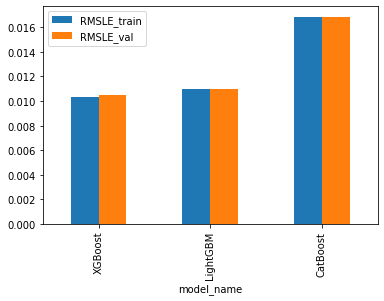

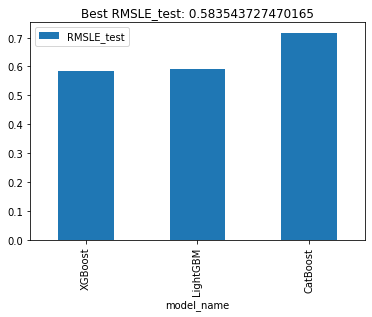

In [ ]:
loss_min = history_models['RMSLE_test'].min()

history_models[['model_name', 'RMSLE_train', 'RMSLE_val']].plot(x='model_name', kind='bar',stacked=False)
history_models[['model_name', 'RMSLE_test']].plot(x='model_name', kind='bar', title='Best RMSLE_test: ' + str(loss_min))

# VI. CẢI THIỆN MÔ HÌNH (MODEL IMPROVEMENT)

## 6.1 Xây dựng đặc trưng mới (Feature Construction)
Xây dựng các đặc trưng mới trên các đặc trưng sẵn có

### 6.1.1 Tạo các đặc trưng mới

#### **meal_week_count**
Trong mỗi tuần (week), mỗi món ăn (meal_id) được đặt hàng tại bao nhiêu trung tâm: Một số loại món ăn có thể được đặt hàng ít hơn đáng kể vào một số tuần trong năm (meal_week_count sẽ giảm nếu không có đặt hàng nào tại trung tâm trong suất một tuần) 

In [ ]:
df_grp = train_data.groupby(['meal_id', 'week'])["id"].count().reset_index() 
df_grp = df_grp.rename(columns={'id':'meal_week_count'})
train_data = pd.merge(train_data, df_grp, on=['meal_id', 'week'], how='left')

#### **discount_amount**
Số tiền giảm giá: Một số món ăn có thể được đặt hàng nhiều hơn khi số tiền được giảm giá nhiều hơn.

In [ ]:
train_data['discount_amount'] = (train_data['base_price'] - train_data['checkout_price'])

#### **discount_ratio**
Tỉ lệ giảm giá: Một số món ăn có thể được đặt hàng nhiều hơn khi được giảm giá nhiều hơn (so với giá gốc)

In [ ]:
train_data["discount_ratio"] = train_data["base_price"] / train_data["checkout_price"] 

**Kiểm tra dữ lại dữ liệu: Không chưa giá trị null, số bản ghi và loại dữ liệu phù hợp**

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 456548 entries, 0 to 456547
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     456548 non-null  int64  
 1   week                   456548 non-null  int64  
 2   center_id              456548 non-null  int64  
 3   meal_id                456548 non-null  int64  
 4   checkout_price         456548 non-null  float64
 5   base_price             456548 non-null  float64
 6   emailer_for_promotion  456548 non-null  int64  
 7   homepage_featured      456548 non-null  int64  
 8   num_orders             456548 non-null  float64
 9   category               456548 non-null  int64  
 10  cuisine                456548 non-null  int64  
 11  city_code              456548 non-null  int64  
 12  region_code            456548 non-null  int64  
 13  center_type            456548 non-null  int64  
 14  op_area                456548 non-nu

### 6.1.2 Lựa chọn đặc trưng

**Lập danh sách tất cả các đặc trưng của dữ liệu**


In [ ]:
features = list(train_data.drop(['id', 'num_orders'], axis=1).columns)
features

['week',
 'center_id',
 'meal_id',
 'checkout_price',
 'base_price',
 'emailer_for_promotion',
 'homepage_featured',
 'category',
 'cuisine',
 'city_code',
 'region_code',
 'center_type',
 'op_area',
 'meal_week_count',
 'discount_amount',
 'discount_ratio']

**Tương quan giữa các đặc trưng sau khi thêm đặc trưng mới**

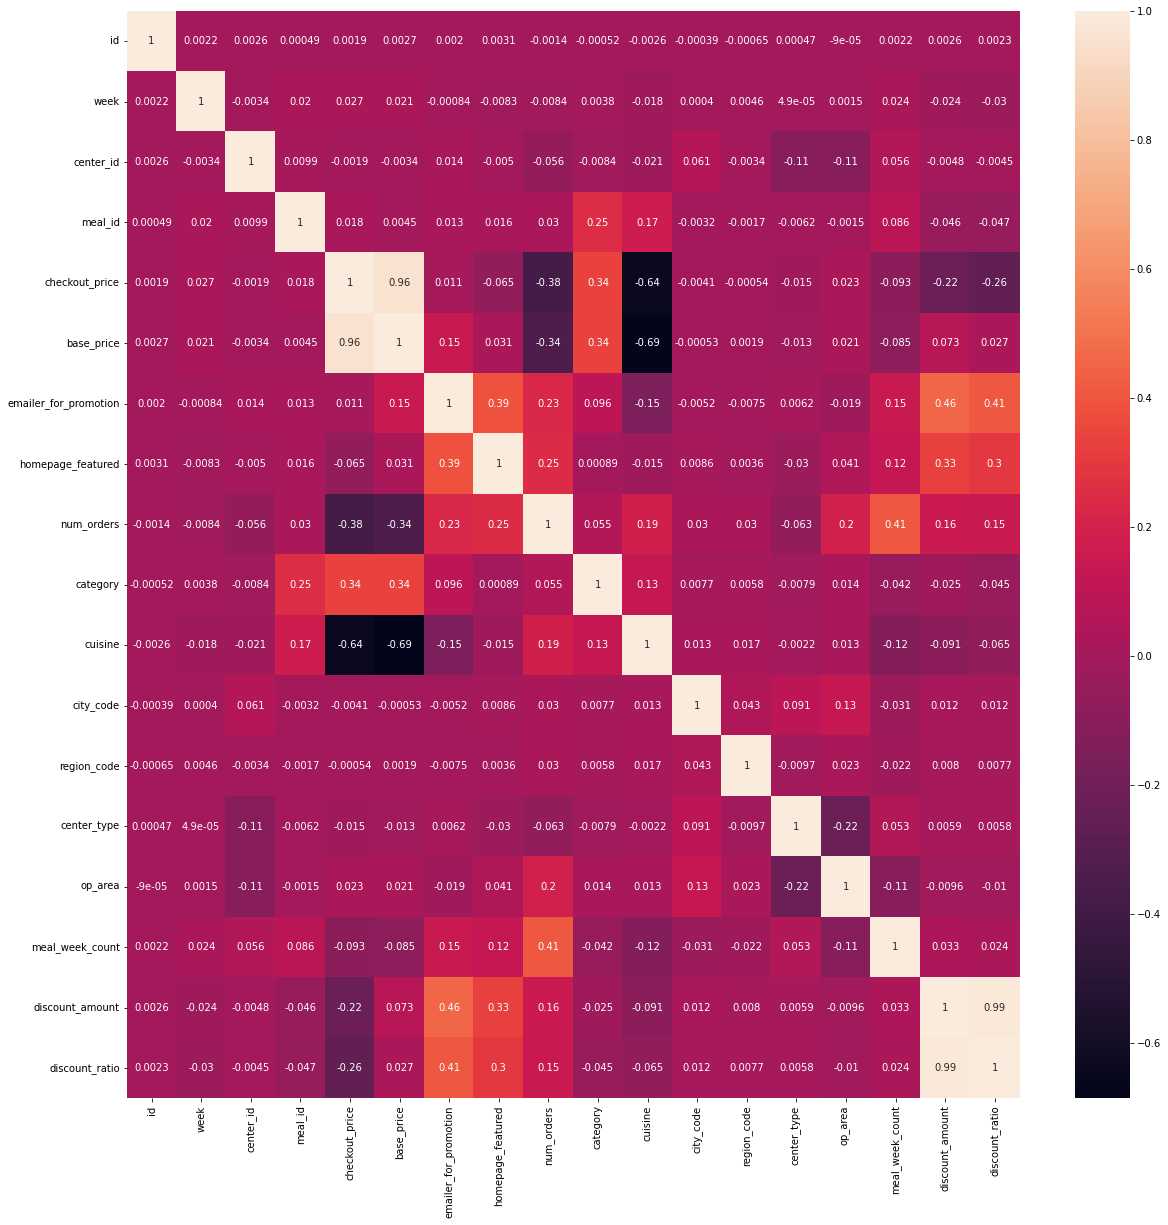

In [ ]:
plt.figure(figsize=(20, 20))
sns.heatmap(train_data.corr(),annot=True)

**Độ lớn giá trị tương quan giữa output (num_orders) và các đặc trưng, từ cao tới thấp**

Đặc trưng mới xây dựng có tương quan cao: meal_week_count              

In [ ]:
abs(train_data.corr()['num_orders']).sort_values(ascending=False)

num_orders               1.000000
meal_week_count          0.407960
checkout_price           0.377399
base_price               0.338953
homepage_featured        0.248957
emailer_for_promotion    0.227997
op_area                  0.195314
cuisine                  0.188148
discount_amount          0.156333
discount_ratio           0.148437
center_type              0.062991
center_id                0.055720
category                 0.054760
city_code                0.030381
meal_id                  0.029933
region_code              0.029817
week                     0.008401
id                       0.001355
Name: num_orders, dtype: float64

**Các đặc trưng được chọn:** 

Chọn tất cả đặc trưng

In [ ]:
features_selected = features.copy()
features_selected

['week',
 'center_id',
 'meal_id',
 'checkout_price',
 'base_price',
 'emailer_for_promotion',
 'homepage_featured',
 'category',
 'cuisine',
 'city_code',
 'region_code',
 'center_type',
 'op_area',
 'meal_week_count',
 'discount_amount',
 'discount_ratio']

### 6.1.3 Chuẩn bị dữ liệu Train/ Validation/ Test

In [ ]:
# Train/ Validation sets
X_train, X_val, y_train, y_val = data_split(train_data[features_selected], train_data['num_orders'])

In [ ]:
# Load & merge data
df_test = pd.read_csv(path + 'test.csv')
test_id = df_test['id']
df_merged_temp = pd.merge(df_test, df_meal, on='meal_id')
test_data = pd.merge(df_merged_temp, df_center, on='center_id')

# Log Transformation
test_data['checkout_price'] = np.log1p(test_data['checkout_price'])
test_data['base_price'] = np.log1p(test_data['base_price'])

# Label encode
le = LabelEncoder()
test_data[features_encode] = test_data[features_encode].apply(le.fit_transform)

# Construct new features
df_grp = test_data.groupby(["meal_id", "week"])["id"].count().reset_index()
df_grp = df_grp.rename(columns={'id':'meal_week_count'})
test_data = pd.merge(test_data,df_grp, on=["meal_id", "week"], how="left")

test_data["discount_ratio"] = test_data["base_price"] / test_data["checkout_price"] 
test_data['discount_amount'] = (test_data['base_price'] - test_data['checkout_price'])

# Test set
X_test = test_data.copy()[features_selected]
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32573 entries, 0 to 32572
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   week                   32573 non-null  int64  
 1   center_id              32573 non-null  int64  
 2   meal_id                32573 non-null  int64  
 3   checkout_price         32573 non-null  float64
 4   base_price             32573 non-null  float64
 5   emailer_for_promotion  32573 non-null  int64  
 6   homepage_featured      32573 non-null  int64  
 7   category               32573 non-null  int64  
 8   cuisine                32573 non-null  int64  
 9   city_code              32573 non-null  int64  
 10  region_code            32573 non-null  int64  
 11  center_type            32573 non-null  int64  
 12  op_area                32573 non-null  float64
 13  meal_week_count        32573 non-null  int64  
 14  discount_amount        32573 non-null  float64
 15  di

### 6.1.4 Huấn luyện & Kiểm tra mô hình


**XGBoost**

In [ ]:
model_name = 'XGBoost'

model = train_model(model_name, params, X_train, y_train, X_val, y_val)
RMSLE_train, RMSLE_val = test_model(model, X_test)

[09:27:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
# Vidhya testing 100*RMSLE = 56.71608346123952
history_models = save_result(model_name, features_selected, params, RMSLE_train, RMSLE_val, RMSLE_test=56.71608346123952)

Training RMSLE   : 0.010193936439408883
Validation RMSLE : 0.0103735053061415
Testing RMSLE    : 0.5671608346123952


**LightGBM**

In [ ]:
model_name = 'LightGBM'

model = train_model(model_name, params, X_train, y_train, X_val, y_val)
RMSLE_train, RMSLE_val = test_model(model, X_test)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [ ]:
# Vidhya testing 100*RMSLE = 57.881703616368995
history_models = save_result(model_name, features_selected, params, RMSLE_train, RMSLE_val, RMSLE_test=57.881703616368995)

Training RMSLE   : 0.01074513875501304
Validation RMSLE : 0.010842550269956378
Testing RMSLE    : 0.57881703616369


**CatBoost**

In [ ]:
model_name = 'CatBoost'

model = train_model(model_name, params, X_train, y_train, X_val, y_val)
RMSLE_train, RMSLE_val = test_model(model, X_test)

In [ ]:
# Vidhya testing 100*RMSLE = 68.70658444108771
history_models = save_result(model_name, features_selected, params, RMSLE_train, RMSLE_val, RMSLE_test=68.70658444108771)

Training RMSLE   : 0.01534758020711267
Validation RMSLE : 0.015386475128594566
Testing RMSLE    : 0.6870658444108771


### 6.1.5 Đánh giá
Chưa đạt tiêu chí (nhỏ hơn 0.525). Tuy nhiên, đã cải thiện so với bộ đặc trưng ban đầu (giảm lỗi RMSLE)
* Không xảy ra over-fit trên tập train/validation của cả 03 model: Lỗi trên 02 tập này tương đương nhau
* Số điểm đánh giá testing tốt nhất (thấp nhất): XGBoost (RMSLE 0.56, giảm 0.02 so với features ban đầu) *# cài đặt tham số mặc định của XGBoost*
* Số điểm đánh giá testing kém nhất (cao nhất): CatBoost (RMSLE 0.69, giảm 0.02 so với features ban đầu) *# tham số chênh lệch lớn so với mặc định (tham số "iterations" mặc định là 1000 so với giá trị cài đặt là 100)*


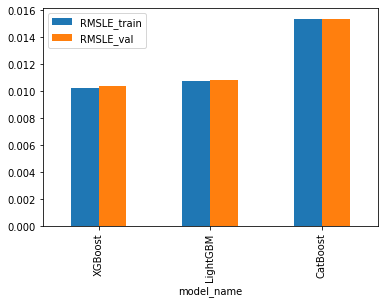

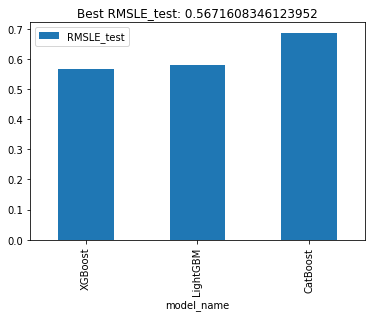

In [ ]:
loss_min = history_models['RMSLE_test'].min()

history_models.tail(3)[['model_name', 'RMSLE_train', 'RMSLE_val']].plot(x='model_name', kind='bar', stacked=False)
history_models.tail(3)[['model_name', 'RMSLE_test']].plot(x='model_name', kind='bar', title='Best RMSLE_test: ' + str(loss_min))

## 6.2 Tinh chỉnh mô hình (Fine Tuning Model)
Tinh chỉnh mô hình trên 03 tham số đã chọn và đánh giá kết quả

### 6.2.1 tree_num

#### tree_num = 1000

In [ ]:
params = dict()
params['tree_depth'] = 6
params['tree_num'] = 1000 
params['L2_reg'] = 1

**XGBoost**

In [ ]:
model_name = 'XGBoost'

model = train_model(model_name, params, X_train, y_train, X_val, y_val)
RMSLE_train, RMSLE_val = test_model(model, X_test)

[09:28:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
# Vidhya testing 100*RMSLE = 53.21572749357162
history_models = save_result(model_name, features_selected, params, RMSLE_train, RMSLE_val, RMSLE_test=53.21572749357162)

Training RMSLE   : 0.007123718225901821
Validation RMSLE : 0.008041503594217863
Testing RMSLE    : 0.5321572749357162


**LightGBM**

In [ ]:
model_name = 'LightGBM'

model = train_model(model_name, params, X_train, y_train, X_val, y_val)
RMSLE_train, RMSLE_val = test_model(model, X_test)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [ ]:
# Vidhya testing 100*RMSLE = 52.64011144273179
history_models = save_result(model_name, features_selected, params, RMSLE_train, RMSLE_val, RMSLE_test=52.64011144273179)

Training RMSLE   : 0.007818894236109703
Validation RMSLE : 0.008340076211959164
Testing RMSLE    : 0.526401114427318


**CatBoost**

In [ ]:
model_name = 'CatBoost'

model = train_model(model_name, params, X_train, y_train, X_val, y_val)
RMSLE_train, RMSLE_val = test_model(model, X_test)

In [ ]:
# Vidhya testing 100*RMSLE = 55.52915032389184
history_models = save_result(model_name, features_selected, params, RMSLE_train, RMSLE_val, RMSLE_test=55.52915032389184)
history_models

Training RMSLE   : 0.010104017178859344
Validation RMSLE : 0.010202800638511264
Testing RMSLE    : 0.5552915032389184


,model_name,features,tree_depth,tree_num,L2_reg,RMSLE_train,RMSLE_val,RMSLE_test
0,XGBoost,"['week', 'center_id', 'meal_id', 'checkout_pri...",6,100,1,0.010339,0.010488,0.583544
1,LightGBM,"['week', 'center_id', 'meal_id', 'checkout_pri...",6,100,1,0.010946,0.011006,0.590573
2,CatBoost,"['week', 'center_id', 'meal_id', 'checkout_pri...",6,100,1,0.016872,0.016884,0.717329
3,XGBoost,"['week', 'center_id', 'meal_id', 'checkout_pri...",6,100,1,0.010194,0.010374,0.567161
4,LightGBM,"['week', 'center_id', 'meal_id', 'checkout_pri...",6,100,1,0.010745,0.010843,0.578817
5,CatBoost,"['week', 'center_id', 'meal_id', 'checkout_pri...",6,100,1,0.015348,0.015386,0.687066
6,XGBoost,"['week', 'center_id', 'meal_id', 'checkout_pri...",6,1000,1,0.007124,0.008042,0.532157
7,LightGBM,"['week', 'center_id', 'meal_id', 'checkout_pri...",6,1000,1,0.007819,0.008340,0.526401
8,CatBoost,"['week', 'center_id', 'meal_id', 'checkout_pri...",6,1000,1,0.010104,0.010203,0.555292


#### tree_num = 1500

In [ ]:
params['tree_num'] = 1500 

**XGBoost**

In [ ]:
model_name = 'XGBoost'

model = train_model(model_name, params, X_train, y_train, X_val, y_val)
RMSLE_train, RMSLE_val = test_model(model, X_test)

[09:29:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
# Vidhya testing 100*RMSLE = 53.802677448791236
history_models = save_result(model_name, features_selected, params, RMSLE_train, RMSLE_val, RMSLE_test=53.802677448791236)

Training RMSLE   : 0.0065838035180333185
Validation RMSLE : 0.00783964143649216
Testing RMSLE    : 0.5380267744879124


**LightGBM**

In [ ]:
model_name = 'LightGBM'

model = train_model(model_name, params, X_train, y_train, X_val, y_val)
RMSLE_train, RMSLE_val = test_model(model, X_test)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [ ]:
# Vidhya testing 100*RMSLE = 52.860117560330856
history_models = save_result(model_name, features_selected, params, RMSLE_train, RMSLE_val, RMSLE_test=52.860117560330856)

Training RMSLE   : 0.007356657506097632
Validation RMSLE : 0.008085177463296116
Testing RMSLE    : 0.5286011756033085


**CatBoost**

In [ ]:
model_name = 'CatBoost'

model = train_model(model_name, params, X_train, y_train, X_val, y_val)
RMSLE_train, RMSLE_val = test_model(model, X_test)

In [ ]:
# Vidhya testing 100*RMSLE = 54.05845449689293
history_models = save_result(model_name, features_selected, params, RMSLE_train, RMSLE_val, RMSLE_test=54.05845449689293)

Training RMSLE   : 0.009550315308205484
Validation RMSLE : 0.009679559506187856
Testing RMSLE    : 0.5405845449689293


### 6.2.2 tree_depth

#### tree_depth = 10

In [ ]:
params = dict()
params['tree_depth'] = 10
params['tree_num'] = 1500 
params['L2_reg'] = 1

**XGBoost**

In [ ]:
model_name = 'XGBoost'

model = train_model(model_name, params, X_train, y_train, X_val, y_val)
RMSLE_train, RMSLE_val = test_model(model, X_test)

[09:31:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
# Vidhya testing 100*RMSLE = 56.36772958210609
history_models = save_result(model_name, features_selected, params, RMSLE_train, RMSLE_val, RMSLE_test=56.36772958210609)

Training RMSLE   : 0.004235417430804256
Validation RMSLE : 0.007669076078488229
Testing RMSLE    : 0.5636772958210609


**LightGBM**

In [ ]:
model_name = 'LightGBM'

model = train_model(model_name, params, X_train, y_train, X_val, y_val)
RMSLE_train, RMSLE_val = test_model(model, X_test)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [ ]:
# Vidhya testing 100*RMSLE = 53.94768906886538
history_models = save_result(model_name, features_selected, params, RMSLE_train, RMSLE_val, RMSLE_test=53.94768906886538)

Training RMSLE   : 0.007068071897728525
Validation RMSLE : 0.007946199672685249
Testing RMSLE    : 0.5394768906886538


**CatBoost**

In [ ]:
model_name = 'CatBoost'

model = train_model(model_name, params, X_train, y_train, X_val, y_val)
RMSLE_train, RMSLE_val = test_model(model, X_test)

In [ ]:
# Vidhya testing 100*RMSLE = 51.197215192415634
history_models = save_result(model_name, features_selected, params, RMSLE_train, RMSLE_val, RMSLE_test=51.197215192415634)

Training RMSLE   : 0.0075896729357859535
Validation RMSLE : 0.008282742711210059
Testing RMSLE    : 0.5119721519241563


#### tree_depth = 15

In [ ]:
params['tree_depth'] = 15 

**XGBoost**

In [ ]:
model_name = 'XGBoost'

model = train_model(model_name, params, X_train, y_train, X_val, y_val)
RMSLE_train, RMSLE_val = test_model(model, X_test)

[09:33:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
# Vidhya testing 100*RMSLE = 58.43127660134299
history_models = save_result(model_name, features_selected, params, RMSLE_train, RMSLE_val, RMSLE_test=58.43127660134299)

Training RMSLE   : 0.002358098833850799
Validation RMSLE : 0.007989747798335315
Testing RMSLE    : 0.5843127660134299


**LightGBM**

In [ ]:
model_name = 'LightGBM'

model = train_model(model_name, params, X_train, y_train, X_val, y_val)
RMSLE_train, RMSLE_val = test_model(model, X_test)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [ ]:
# Vidhya testing 100*RMSLE = 55.45529280710176
history_models = save_result(model_name, features_selected, params, RMSLE_train, RMSLE_val, RMSLE_test=55.45529280710176)

Training RMSLE   : 0.0070481390580904146
Validation RMSLE : 0.007942050583915198
Testing RMSLE    : 0.5545529280710176


**CatBoost**

In [ ]:
model_name = 'CatBoost'

model = train_model(model_name, params, X_train, y_train, X_val, y_val)
RMSLE_train, RMSLE_val = test_model(model, X_test)

In [ ]:
# Vidhya testing 100*RMSLE = 53.754537403647284
history_models = save_result(model_name, features_selected, params, RMSLE_train, RMSLE_val, RMSLE_test=53.754537403647284)

Training RMSLE   : 0.004870923250987158
Validation RMSLE : 0.008010601742197568
Testing RMSLE    : 0.5375453740364728


### 6.2.3 L2_reg

#### L2_reg = 5

In [ ]:
params = dict()
params['tree_depth'] = 15
params['tree_num'] = 1500 
params['L2_reg'] = 5

**XGBoost**

In [ ]:
model_name = 'XGBoost'

model = train_model(model_name, params, X_train, y_train, X_val, y_val)
RMSLE_train, RMSLE_val = test_model(model, X_test)

[09:38:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
# Vidhya testing 100*RMSLE = 58.43127660134299
history_models = save_result(model_name, features_selected, params, RMSLE_train, RMSLE_val, RMSLE_test=58.43127660134299)

Training RMSLE   : 0.002358098833850799
Validation RMSLE : 0.007989747798335315
Testing RMSLE    : 0.5843127660134299


**LightGBM**

In [ ]:
model_name = 'LightGBM'

model = train_model(model_name, params, X_train, y_train, X_val, y_val)
RMSLE_train, RMSLE_val = test_model(model, X_test)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [ ]:
# Vidhya testing 100*RMSLE = 55.69834689
history_models = save_result(model_name, features_selected, params, RMSLE_train, RMSLE_val, RMSLE_test=55.69834689)

Training RMSLE   : 0.007076558688017977
Validation RMSLE : 0.007930621565922311
Testing RMSLE    : 0.5569834689000001


**CatBoost**

In [ ]:
model_name = 'CatBoost'

model = train_model(model_name, params, X_train, y_train, X_val, y_val)
RMSLE_train, RMSLE_val = test_model(model, X_test)

In [ ]:
# Vidhya testing 100*RMSLE = 53.27831373693223
history_models = save_result(model_name, features_selected, params, RMSLE_train, RMSLE_val, RMSLE_test=53.27831373693223)

Training RMSLE   : 0.005143277294728332
Validation RMSLE : 0.007997051512951376
Testing RMSLE    : 0.5327831373693224


#### L2_reg = 10

In [ ]:
params['L2_reg'] = 10

**XGBoost**

In [ ]:
model_name = 'XGBoost'

model = train_model(model_name, params, X_train, y_train, X_val, y_val)
RMSLE_train, RMSLE_val = test_model(model, X_test)

[09:43:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
# Vidhya testing 100*RMSLE = 58.43127660134299
history_models = save_result(model_name, features_selected, params, RMSLE_train, RMSLE_val, RMSLE_test=58.43127660134299)

Training RMSLE   : 0.002358098833850799
Validation RMSLE : 0.007989747798335315
Testing RMSLE    : 0.5843127660134299


**LightGBM**

In [ ]:
model_name = 'LightGBM'

model = train_model(model_name, params, X_train, y_train, X_val, y_val)
RMSLE_train, RMSLE_val = test_model(model, X_test)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [ ]:
# Vidhya testing 100*RMSLE = 54.74029883082097
history_models = save_result(model_name, features_selected, params, RMSLE_train, RMSLE_val, RMSLE_test=54.74029883082097)

Training RMSLE   : 0.007117825121161713
Validation RMSLE : 0.00794113102480595
Testing RMSLE    : 0.5474029883082097


**CatBoost**

In [ ]:
model_name = 'CatBoost'

model = train_model(model_name, params, X_train, y_train, X_val, y_val)
RMSLE_train, RMSLE_val = test_model(model, X_test)

In [ ]:
# Vidhya testing 100*RMSLE = 53.0089930063408
history_models = save_result(model_name, features_selected, params, RMSLE_train, RMSLE_val, RMSLE_test=53.0089930063408)

Training RMSLE   : 0.005567896996401069
Validation RMSLE : 0.007986604633123725
Testing RMSLE    : 0.530089930063408


### 6.2.4 Đánh giá
Đạt tiêu chí (nhỏ hơn 0.525). Đã cải thiện so với các model gốc (giảm lỗi RMSLE)
* RMSLE tốt nhất (thấp nhất): CatBoost (RMSLE 0.51 giảm 0.06 so với params ban đầu) với tree_depth=10, tree_num=1500, L2_reg=1
* Model có RMSLE kém nhất (cao nhất): XGBoost 


**RMSLE các mô hình được huấn luyện với các đặc trưng (bao gồm các đặc trưng mới) và các tham số được tinh chỉnh:**

21 bản ghi bao gồm: 3 model gốc + 18 model tinh chỉnh


In [ ]:
# Create df for plotting
def create_df_plot(df):
  df_plot = df.copy()
  df_plot['params'] = df_plot['tree_depth'].astype(str) + ',' + df_plot['tree_num'].astype(str) + ',' + df_plot['L2_reg'].astype(str)
  return df_plot

# Best model info
def best_result(df):
  loss_min = df['RMSLE_test'].min()
  model_best = df[df['RMSLE_test']==loss_min]['model_name'].item()
  str_params_best = df[df['RMSLE_test']==loss_min]['params'].item()
  params_best_lst = [int(i) for i in str_params_best.split(',')]
  params_best = dict()
  params_best['tree_depth'] = params_best_lst[0]
  params_best['tree_num'] = params_best_lst[1]
  params_best['L2_reg'] = params_best_lst[2]
  return model_best, loss_min, params_best, str_params_best

# Plotting function
def plot_models(df, model_best, loss_min, str_params_best, model_names, colors):
  fig = plt.figure(figsize=(15, 5))
  ax = fig.add_axes([0, 0, 1, 1])

  for i, model_name in enumerate(model_names):
    df_model = df[df['model_name']==model_name]
    plt.plot(df_model['params'], df_model['RMSLE_test'], label=model_name, color=colors[i])

  text =  'Best RMSLE : ' + str(loss_min) + '\n'
  text += 'Best Model : ' + model_best + '\n'
  text += 'Best Params: ' + str_params_best

  plt.text(0.15, 0.85, text, fontsize=12, transform = ax.transAxes)
  plt.legend()
  plt.xlabel('Params (tree_depth, tree_num, L2_reg)')
  plt.ylabel('RMSLE_test')
  plt.show()

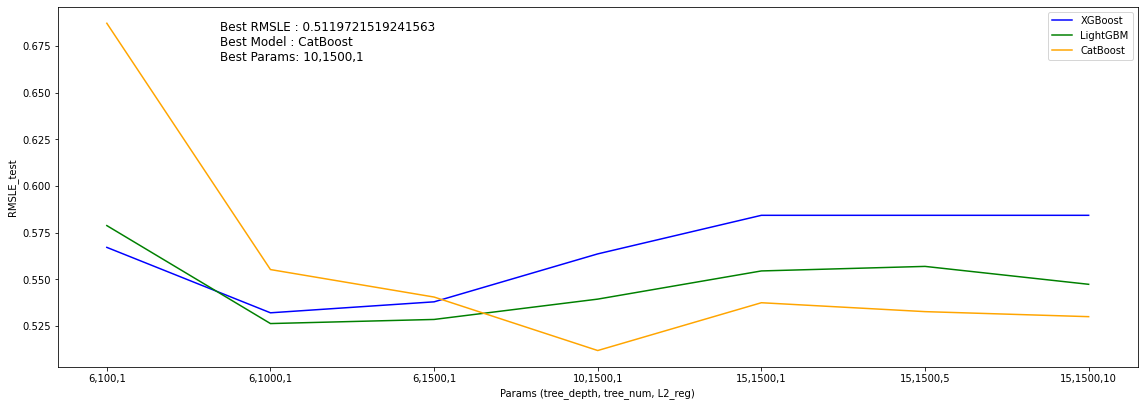

In [ ]:
history_models = pd.read_csv(path + 'history_models.csv', index_col=None)

df_plot = create_df_plot(history_models.iloc[3:, :]) # not plotting the 3 first rows because they not use added features
model_best, loss_min, params_best, str_params_best = best_result(create_df_plot(history_models))
plot_models(df_plot, model_best, loss_min, str_params_best, ['XGBoost', 'LightGBM', 'CatBoost'], ['blue', 'green', 'orange'])

### 6.2.5 Tinh chỉnh bổ sung

Tiếp tục tinh chỉnh để có kết quả tốt hơn

Chọn 01 model có RMSLE tôt nhất tại bước trước đó (CatBoost) và tiếp tục tinh chỉnh

Bắt đầu từ bộ tham số tốt nhất tại bước trước (10, 1500, 1), tiếp tục tinh chỉnh các tham số với các giá trị dưới đây:


In [ ]:
# Save model with smallest RMSLE_test
def save_best_model(model, loss_min, df_history):
  if loss_min > df_history['RMSLE_test'].min():
    model.save_model(path + "model_best", format="cbm")

**tree_depth**

Do RMSLE_test giảm khi tree_depth tăng từ 6-10 và tăng khi tree_depth tăng từ 10-15, tinh chỉnh với giá trị ở giữa 10-15 (12 & 14)

tree_depth=12

In [ ]:
params = dict()
params['tree_depth'] = 12
params['tree_num'] = 1500 
params['L2_reg'] = 1

In [ ]:
model_name = 'CatBoost'

model = train_model(model_name, params, X_train, y_train, X_val, y_val)
RMSLE_train, RMSLE_val = test_model(model, X_test)

In [ ]:
# Vidhya testing 100*RMSLE = 50.785216596834296
loss_min = history_models['RMSLE_test'].min()
history_models = save_result(model_name, features_selected, params, RMSLE_train, RMSLE_val, RMSLE_test=50.785216596834296)
save_best_model(model, loss_min, history_models)

Training RMSLE   : 0.006470685573170951
Validation RMSLE : 0.007976627554739709
Testing RMSLE    : 0.5078521659683429


tree_depth=14

In [ ]:
params['tree_depth'] = 14

In [ ]:
model = train_model(model_name, params, X_train, y_train, X_val, y_val)
RMSLE_train, RMSLE_val = test_model(model, X_test)

In [ ]:
# Vidhya testing 100*RMSLE = 50.930362368085845
loss_min = history_models['RMSLE_test'].min()
history_models = save_result(model_name, features_selected, params, RMSLE_train, RMSLE_val, RMSLE_test=50.930362368085845)
save_best_model(model, loss_min, history_models)

Training RMSLE   : 0.005133094671649612
Validation RMSLE : 0.007939160020021083
Testing RMSLE    : 0.5093036236808585


RMSLE tốt nhất (thấp nhất) với tree_depth=12

In [ ]:
tree_depth_best = 12

**tree_num**

Do RMSLE_test giảm khi tree_num tăng từ 100-1500, tiếp tục tăng tree_num lên các giá trị 1700 & 2000 (Sử dụng tree_depth tốt nhất đã tìm ở bước trước đó)

tree_num=1700

In [ ]:
params = dict()
params['tree_depth'] = tree_depth_best
params['tree_num'] = 1700 
params['L2_reg'] = 1

In [ ]:
model_name = 'CatBoost'

model = train_model(model_name, params, X_train, y_train, X_val, y_val)
RMSLE_train, RMSLE_val = test_model(model, X_test)

In [ ]:
# Vidhya testing 100*RMSLE = 50.795410680110955
loss_min = history_models['RMSLE_test'].min()
history_models = save_result(model_name, features_selected, params, RMSLE_train, RMSLE_val, RMSLE_test=50.795410680110955)
save_best_model(model, loss_min, history_models)

Training RMSLE   : 0.006251638107006935
Validation RMSLE : 0.007933679380327794
Testing RMSLE    : 0.5079541068011095


tree_num=2000

In [ ]:
params['tree_num'] = 2000

In [ ]:
model_2 = train_model(model_name, params, X_train, y_train, X_val, y_val)
RMSLE_train, RMSLE_val = test_model(model_2, X_test)

In [ ]:
# Vidhya testing 100*RMSLE = 50.896318103253414
loss_min = history_models['RMSLE_test'].min()
history_models = save_result(model_name, features_selected, params, RMSLE_train, RMSLE_val, RMSLE_test=50.896318103253414)
save_best_model(model, loss_min, history_models)

Training RMSLE   : 0.005961500576746433
Validation RMSLE : 0.00788485505935681
Testing RMSLE    : 0.5089631810325341


RMSLE không có cải thiện. Giữ nguyên tree_num trước khi tinh chỉnh (1500)

In [ ]:
tree_num_best = 1500

**L2_reg**

Do RMSLE_test chỉ giảm nhẹ khi L2_reg tăng từ 1-10, tinh chỉnh L2_reg tại các giá trị giữa 1-10 là 4 & 7 (Sử dụng tree_depth, tree_num tốt nhất đã tìm ở các bước trước đó)

L2_reg=4

In [ ]:
params = dict()
params['tree_depth'] = tree_depth_best
params['tree_num'] = tree_num_best
params['L2_reg'] = 4

In [ ]:
model_name = 'CatBoost'

model = train_model(model_name, params, X_train, y_train, X_val, y_val)
RMSLE_train, RMSLE_val = test_model(model, X_test)

In [ ]:
# Vidhya testing 100*RMSLE = 50.4274229095038
loss_min = history_models['RMSLE_test'].min()
history_models = save_result(model_name, features_selected, params, RMSLE_train, RMSLE_val, RMSLE_test=50.4274229095038)
save_best_model(model, loss_min, history_models)

Training RMSLE   : 0.006729575598280238
Validation RMSLE : 0.008001439525915978
Testing RMSLE    : 0.5042742290950379


L2_reg=7

In [ ]:
params['L2_reg'] = 7

In [ ]:
model = train_model(model_name, params, X_train, y_train, X_val, y_val)
RMSLE_train, RMSLE_val = test_model(model, X_test)

In [ ]:
# Vidhya testing 100*RMSLE = 50.6054869669888
loss_min = history_models['RMSLE_test'].min()
history_models = save_result(model_name, features_selected, params, RMSLE_train, RMSLE_val, RMSLE_test=50.6054869669888)
save_best_model(model, loss_min, history_models)

Training RMSLE   : 0.006871560131899411
Validation RMSLE : 0.008025304088959144
Testing RMSLE    : 0.506054869669888


RMSLE tốt nhất (thấp nhất) với L2_reg_best=4

In [ ]:
L2_reg_best = 4

### 6.2.6 Đánh giá cuối cùng

RMSLE_test tiếp tục được cải thiện (giảm 0.01 so với kết quả tốt nhất trước đó), đạt giá trị 0.504 (tương ứng với điểm số trên Vidhya là 50.4), tốt hơn 0.02 so với tiêu chí.

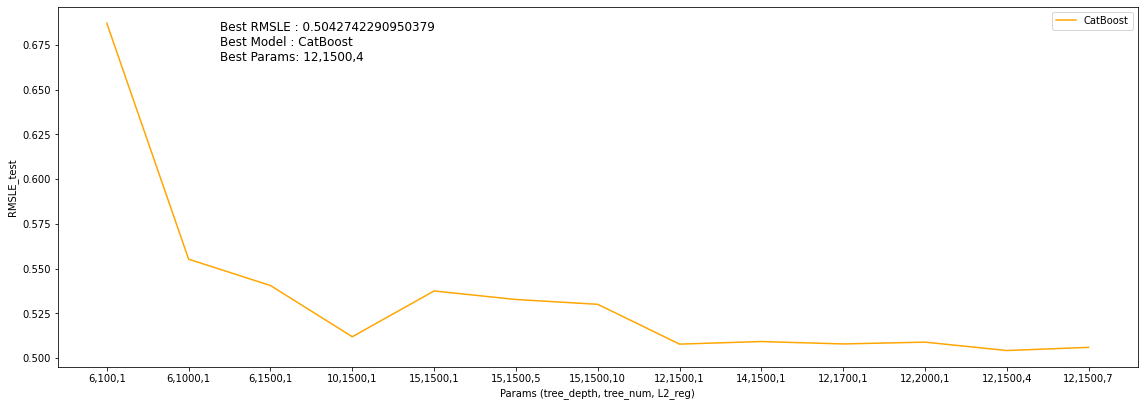

In [ ]:
history_models = pd.read_csv(path + 'history_models.csv', index_col=None)

df_plot = create_df_plot(history_models.iloc[3:, :]) # not plotting the 3 first rows because they not use added features
model_best, loss_min, params_best, str_params_best = best_result(create_df_plot(history_models))
plot_models(df_plot, model_best, loss_min, str_params_best, ['CatBoost'], ['orange'])

# VII. MÔ HÌNH CUỐI CÙNG (FINAL MODEL)

Mô hình cho kết quả tốt nhất là CatBoost với các cấu hình & kết quả dự đoán như sau:

**Tham số (Parameter):**

In [ ]:
model = CatBoostRegressor().load_model(path + 'model_best', format='cbm')
model.get_params()

{'loss_function': 'RMSE',
 'od_wait': 20,
 'verbose': 0,
 'od_type': 'Iter',
 'iterations': 1500,
 'l2_leaf_reg': 4,
 'task_type': 'GPU',
 'depth': 12,
 'random_seed': 9}

Các đặc trưng của dữ liệu đầu vào (Features):

In [ ]:
features_selected

['week',
 'center_id',
 'meal_id',
 'checkout_price',
 'base_price',
 'emailer_for_promotion',
 'homepage_featured',
 'category',
 'cuisine',
 'city_code',
 'region_code',
 'center_type',
 'op_area',
 'meal_week_count',
 'discount_amount',
 'discount_ratio']

**Kết quả dự đoán trên tập kiểm tra:**

In [ ]:
submission = get_prediction_test(model, X_test)
submission

,id,num_orders
0,1028232,172
1,1127204,121
2,1212707,104
3,1082698,47
4,1400926,34
...,...,...
32568,1250239,55
32569,1039516,30
32570,1158107,237
32571,1444235,260
